In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
import os
import itertools
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.style.use('seaborn')
pd.options.display.max_rows = 4000
%matplotlib inline
pd.set_option('display.max_columns', 100)

Cleaning Up Data

In [2]:
df_NBA = pd.read_csv('1985_2000_draft_class_NBA.csv',index_col=0)
df_NCAA= pd.read_csv('NCAA_Stats.csv',index_col=0)

In [3]:
df_NCAA.fillna(0, inplace=True)
df_NBA.fillna(0, inplace=True)

In [4]:
df_NCAA['2P']= np.where(df_NCAA['2P']==0, df_NCAA['FG'], df_NCAA['2P'])
df_NCAA['2PA']= np.where(df_NCAA['2PA']==0, df_NCAA['FGA'], df_NCAA['2PA'])
df_NCAA['2P%']= np.where(df_NCAA['2P%']==0, df_NCAA['FG%'], df_NCAA['2P%'])

Combining Data for EDA, Feature Creation and Modeling

In [5]:
columns2drop= ['Pick', 'Team', 'College', 'G', 'MP', 'PTS', 'TRB',
       'AST', 'FG%', '3P%', 'FT%', 'MP.1', 'PTS.1', 'TRB.1', 'AST.1', 'WS',
       'WS/48', 'BPM', 'VORP', 'Position3']
df_NBA.drop(columns= columns2drop, inplace= True)

In [6]:
df = df_NCAA.merge(df_NBA, on='Name', how='inner')

Feature Creation

In [7]:
df['Birthday']= pd.to_datetime(df['Birthday'])
df['Birthday']= df['Birthday'].dt.year

In [8]:
df['Age'] = df['Year']-df['Birthday']

In [9]:
df.drop(columns= ['Year','Birthday'], inplace= True)

In [10]:
df['Height'] = (df['Height'].str.strip('cm').astype(int))
df['Weight'] = (df['Weight'].str.strip('kg').astype(int))

In [11]:
# engineered a metric called assist to turnover ratio which is popular today
df['AST_TOV'] = df['AST']/df['TOV']
# engineered true fg% which takes into account pts, fga, fta
df['True_FG%'] = df['PTS']/(2*df['FGA'] + (.44*df['FTA']))*100
# engineered points per possession metric which is also very widely used today
df['PPP'] = df['PTS']/(df['FGA']+(0.44*df['FTA'])+df['TOV'])
# engineered free throw rate
df['FTR'] = (df['FTA']/df['FGA'])*100
# engineered a players turn over rate%
df['TOV%'] = df['TOV']/(df['FGA']+0.44 * df['FTA']+df['TOV'])*100
# engineered the hollinger assist ratio
df['Hasst%'] = df['AST']/(df['FGA']+.475 * df['FTA']+df['AST']+df['TOV'])*100

In [12]:
#Fix infinite numbers created
df['AST_TOV']= np.where(df['AST_TOV']== np.inf, (df['AST']/1), df['AST_TOV'])
df= df.fillna(0)

In [13]:
df.isna().sum()

Name             0
Yrs_College      0
School           0
Conf             0
G                0
MP               0
FG               0
FGA              0
FG%              0
2P               0
2PA              0
2P%              0
3P               0
3PA              0
3P%              0
FT               0
FTA              0
FT%              0
TRB              0
AST              0
STL              0
BLK              0
TOV              0
PF               0
PTS              0
SOS              0
Yrs              0
Height           0
Weight           0
Position1        0
Position2        0
All_Star_apps    0
All_NBA_apps     0
All_Def_apps     0
HOF              0
Age              0
AST_TOV          0
True_FG%         0
PPP              0
FTR              0
TOV%             0
Hasst%           0
dtype: int64

In [14]:
#create value to predict
df['Status']= np.where(df['Yrs']>4,1,0)
df['Status']= np.where(df['All_Star_apps']>0, 2, df['Status'])
df['Status']= np.where(df['All_Def_apps']>0, 2, df['Status'])
df['Status']= np.where(df['All_NBA_apps']>0, 3, df['Status'])
df['Status']= np.where(df['HOF']=='Hall of Fame', 4, df['Status'])

In [15]:
df.drop(columns=['All_Star_apps','All_Def_apps', 'All_NBA_apps', 'HOF', 'Name','Yrs'], inplace= True)

Modeling

In [18]:
df3= pd.get_dummies(data=df, columns=['School','Conf','Position1','Position2'])
df2= df.drop(columns=['School','Conf','Position1','Position2', 'Height'])

In [19]:
target = df2['Status']
features = df2.drop(['Status'], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25,test_size=0.30)

log = LogisticRegression()
log.fit(X_train, y_train)
log_preds = log.predict(X_test)

log_f1 = metrics.f1_score(y_test, log_preds, average='macro')
log_acc = metrics.accuracy_score(y_test, log_preds)

print('Test f1 score: ', log_f1)
print('Test Accuracy score: ', log_acc)

Test f1 score:  0.23618551891772444
Test Accuracy score:  0.545045045045045


/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
for x in X_test.columns:
    X_train1= X_train.drop(columns=x)
    X_test1=X_test.drop(columns=x)
    y_train1=y_train.drop(columns=x)
    y_test1=y_test.drop(columns=x)
    lr = LogisticRegression()
    lr.fit(X_train1, y_train1)
    lr_preds = lr.predict(X_test1)
    lr_f1 = metrics.f1_score(y_test1, lr_preds, average='macro')
    lr_acc = metrics.accuracy_score(y_test1, lr_preds)
    if lr_f1 > log_f1 or lr_acc > log_acc:
        print(x,'LR Test Accuracy score: ', lr_acc, (lr_acc-log_acc))
        print(x,'LR Test F1 score: ', lr_f1, (lr_f1-log_f1))
    else:
        continue

/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

2PA LR Test Accuracy score:  0.545045045045045 0.0
2PA LR Test F1 score:  0.23668691007536405 0.0005013911576396135
2P% LR Test Accuracy score:  0.5540540540540541 0.009009009009009028
2P% LR Test F1 score:  0.23960420531849103 0.0034186864007665907


/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

BLK LR Test Accuracy score:  0.5495495495495496 0.0045045045045045695
BLK LR Test F1 score:  0.23837467378844418 0.002189154870719745
TOV LR Test Accuracy score:  0.5495495495495496 0.0045045045045045695
TOV LR Test F1 score:  0.23805588351042895 0.0018703645927045098
Weight LR Test Accuracy score:  0.5540540540540541 0.009009009009009028
Weight LR Test F1 score:  0.24017408123791104 0.0039885623201866005


/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

Seemingly poor performance by Logistic regression model

F-Test Feature Selection:

In [22]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train)
#transform the training data
X_train1 = pd.DataFrame(data = scaler.transform(X_train), columns = features.columns)
#transform the testing dat
X_test1 = pd.DataFrame(data = scaler.transform(X_test), columns = features.columns)

selector = SelectKBest(f_regression, k=22)

selector.fit(X_train1, y_train)

selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

log_kbest = LogisticRegression()
log_kbest = log_kbest.fit(X_train1[selected_columns], y_train)

log_kpreds = log_kbest.predict(X_test1[selected_columns])

log_kf1 = metrics.f1_score(y_test, log_kpreds,average='macro')
log_kacc = metrics.accuracy_score(y_test, log_kpreds)
print('Test F1 Score:', log_kf1)
print('Test Accuracy score: ', log_kacc)

Test F1 Score: 0.24029401608208772
Test Accuracy score:  0.5495495495495496


Slightly Better, Lets see if gridsearch can give us better parameters to help out

In [23]:
logreg = LogisticRegression()
parameters = {'C': [0.25,0.35,0.5,0.75,1.0],
             'max_iter': [100,200,300,400,500],
             'penalty': ['l1', 'l2']}
grid_tree1=GridSearchCV(logreg, parameters, cv=5, scoring='f1_macro',verbose =1,n_jobs=-1)

grid_tree1.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 235 out of 250 | elapsed:    7.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    7.7s finished
/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.25, 0.35, 0.5, 0.75, 1.0],
                         'max_iter': [100, 200, 300, 400, 500],
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro', verbose=1)

In [24]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree1.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree1.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree1.best_estimator_)

0.29012377269998446
{'C': 0.75, 'max_iter': 300, 'penalty': 'l2'}
LogisticRegression(C=0.75, max_iter=300)


In [25]:
#Predict the response for test dataset
y_pred = grid_tree1.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Test F1 Score:",metrics.f1_score(y_test, y_pred, average= 'macro'))
print("Test Accuracy Score:",metrics.accuracy_score(y_test, y_pred))

Test F1 Score: 0.24447691408533018
Test Accuracy Score: 0.5630630630630631


No Bueno, How about if we gridsearch our Log Reg with F-Test?

In [26]:
logreg_kbest = LogisticRegression(class_weight = 'balanced')
parameters = {'C': [0.25,0.35,0.5,0.75,1.0],
             'max_iter': [100,200,300,400,500]}
grid_tree2=GridSearchCV(logreg_kbest, parameters, cv=5, scoring='f1_macro',verbose =1,n_jobs=-1)

grid_tree2.fit(X_train1[selected_columns], y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 110 out of 125 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.6s finished


GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [0.25, 0.35, 0.5, 0.75, 1.0],
                         'max_iter': [100, 200, 300, 400, 500]},
             scoring='f1_macro', verbose=1)

In [27]:
#Predict the response for test dataset
y_pred = grid_tree2.best_estimator_.predict(X_test1[selected_columns])

# Model Accuracy, how often is the classifier correct?
print("Test F1 Score:",metrics.f1_score(y_test, y_pred, average= 'macro'))
print("Test Accuracy Score:",metrics.accuracy_score(y_test, y_pred))

Test F1 Score: 0.24437985143420451
Test Accuracy Score: 0.34684684684684686


No difference from our original F-Test Model

Maybe KNN will work better?

In [28]:
scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train)
#transform the training data
X_train1 = pd.DataFrame(data = scaler.transform(X_train), columns = features.columns)
#transform the testing data
X_test1 = pd.DataFrame(data = scaler.transform(X_test), columns = features.columns)

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train1, y_train)

knn_preds = knn.predict(X_test1)

knn_f1 = metrics.f1_score(y_test, knn_preds, average='macro')

knn_acc = metrics.accuracy_score(y_test, knn_preds)

print('Test f1 score: ', knn_f1)
print('Test Accuracy score: ', knn_acc)

Test f1 score:  0.21061643835616434
Test Accuracy score:  0.4864864864864865


Decision Tree

In [29]:
dtc = DecisionTreeClassifier(random_state = 25)

dtc.fit(X_train, y_train)

dtc_preds  = dtc.predict(X_test)

dtc_f1 = metrics.f1_score(y_test, dtc_preds, average='macro')

dtc_acc = metrics.accuracy_score(y_test, dtc_preds)

print('Test F1 score: ', dtc_f1)
print('Test Accuracy score: ', dtc_acc)

Test F1 score:  0.26063113759240863
Test Accuracy score:  0.4594594594594595


Random Forest

In [30]:
rfc = RandomForestClassifier(random_state = 25, n_estimators=200, max_features=10)
rfc.fit(X_train, y_train)
rfc_preds = rfc.predict(X_test)

rfc_f1 = metrics.f1_score(y_test, rfc_preds, average='macro')
rfc_acc = metrics.accuracy_score(y_test, rfc_preds)

# checking accuracy on the test data
print('Test F1 score: ', rfc_f1)
print('Test Accuracy score: ', rfc_acc)

Test F1 score:  0.2262990713125288
Test Accuracy score:  0.5225225225225225


GridSearch Random Forest

In [31]:
param_grid2 = { 
    'n_estimators': [100,200,400,500],
    'max_features': [10],
    'max_depth' : [4,5,6],
    'criterion' : ['gini','entropy']
    
}

rfc_CV = RandomForestClassifier(random_state = 25)
rfc_CV = GridSearchCV(estimator=rfc_CV, param_grid=param_grid2, cv= 5, scoring='f1_macro', verbose=1, n_jobs=-1)
rfc_CV.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   37.3s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=25), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6], 'max_features': [10],
                         'n_estimators': [100, 200, 400, 500]},
             scoring='f1_macro', verbose=1)

In [32]:
# Identify the best params 
print(rfc_CV.best_params_)
print(rfc_CV.best_estimator_)


#Identify the best score during fitting with cross-validation
print(rfc_CV.best_score_)

#predict on the test set
test_preds_rfc_CV = rfc_CV.best_estimator_.predict(X_test)

# checking accuracy and F1
print("Accuracy:",metrics.accuracy_score(y_test, test_preds_rfc_CV))
print("F1:",metrics.f1_score(y_test, test_preds_rfc_CV, average='macro'))

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 10, 'n_estimators': 100}
RandomForestClassifier(criterion='entropy', max_depth=5, max_features=10,
                       random_state=25)
0.22923204943842582
Accuracy: 0.5405405405405406
F1: 0.23121358743951811


Voting Classifier:

In [33]:
voting_clf = VotingClassifier(
                estimators=[('knneighbors', knn), ('decisiontree', dtc), ('logreg', log), ('randomforest', rfc)], 
                voting='hard', weights= [1,3,3,3])

voting_clf.fit(X_train, y_train)

vc_preds = voting_clf.predict(X_test)

vc_f1 = metrics.f1_score(y_test, vc_preds, average='macro')

vc_acc = metrics.accuracy_score(y_test, vc_preds)

print('Test F1 score: ', vc_f1)
print('Test Accuracy score: ', vc_acc)

/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test F1 score:  0.25319990236758605
Test Accuracy score:  0.5855855855855856


XG Boost:

In [41]:
labels = df3['Status']
labels_removed_df = df3.drop(columns='Status')

scaler = StandardScaler()
scaled_df = scaler.fit_transform(labels_removed_df)

X_train, X_test, y_train, y_test = train_test_split(scaled_df, labels)

In [42]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [5,6,7],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [100,200,250,300],
}

In [43]:
clf = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='f1_macro', cv=5, n_jobs=-1,verbose=1)
grid_clf.fit(scaled_df, labels)
best_parameters = grid_clf.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)
f1_train= f1_score(y_train, training_preds, average='macro')
f1_val= f1_score(y_test, val_preds, average='macro')
print("")
print("Training Accuracy Score: {:.4}%".format(training_accuracy * 100))
print("Training F1 Score: {:.4}%".format(f1_train * 100))
print("Test Accuracy Score: {:.4}%".format(val_accuracy * 100))
print("Test F1 Score: {:.4}%".format(f1_val * 100))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.4min finished


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 5
min_child_weight: 10
n_estimators: 250
subsample: 0.7

Training Accuracy Score: 97.3%
Training F1 Score: 77.29%
Test Accuracy Score: 96.76%
Test F1 Score: 71.63%


XG-Boost is clearly the best model, but what is it missing?

Confusion Matrix for XG-Boost

In [44]:
cm = confusion_matrix(y_test,val_preds)
classes = ['Bust', 'Vet','All-Star/All-Defense','All-Pro', 'HOF']

In [45]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[75  0  0  0  0]
 [ 0 87  0  0  0]
 [ 0  0 15  0  0]
 [ 0  3  1  0  0]
 [ 0  1  1  0  2]]


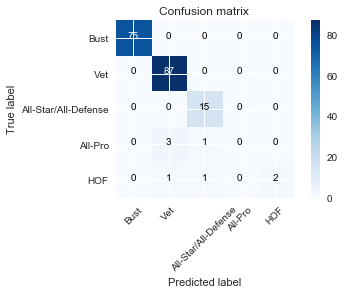

In [46]:
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)

The model predicted perfectly on the Bust, Vet and All-Star/All-Defense. It struggled to predict All-Pro and predicted HOF at 50%